# Mask R-CNN for instance segmentation

This notebook is heavily based on [this tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html). The main goal here is to take a Mask R-CNN model pre-trained on the COCO dataset and fine-tune it on the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). Let start with downloading the dataset:

In [1]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2021-11-29 09:39:07--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  66.6MB/s    in 0.8s    

2021-11-29 09:39:08 (66.6 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

We will rely on torchvision heavily. E.g., we'll take its pre-trained Mask R-CNN model, and we'll also re-use some of the object-detection code. To get the correct version of the code, check out the installed version of torchvision:

In [2]:
import torchvision
print(torchvision.__version__)

0.11.1+cu111


As of time of preparing this notebook, the torchvision version installed in Colab is 0.11.1. So that's the tag we'll use to download the required source files (make sure to find the tag matching your version of torchvision):

In [3]:
TORCHVISION_TAG = "v0.11.1"
!wget https://raw.githubusercontent.com/pytorch/vision/{TORCHVISION_TAG}/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/{TORCHVISION_TAG}/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/{TORCHVISION_TAG}/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/{TORCHVISION_TAG}/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/{TORCHVISION_TAG}/references/detection/coco_eval.py

--2021-11-29 09:39:15--  https://raw.githubusercontent.com/pytorch/vision/v0.11.1/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10434 (10K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  10.19K  --.-KB/s    in 0s      

2021-11-29 09:39:15 (51.9 MB/s) - ‘transforms.py’ saved [10434/10434]

--2021-11-29 09:39:15--  https://raw.githubusercontent.com/pytorch/vision/v0.11.1/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8387 (

Let's create a torch dataset for the Penn-Fudan database that we downloaded earlier:

In [4]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Now we'll create an instance of the newly defined dataset and have a look at some of its examples.

In [5]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  if sys.path[0] == '':


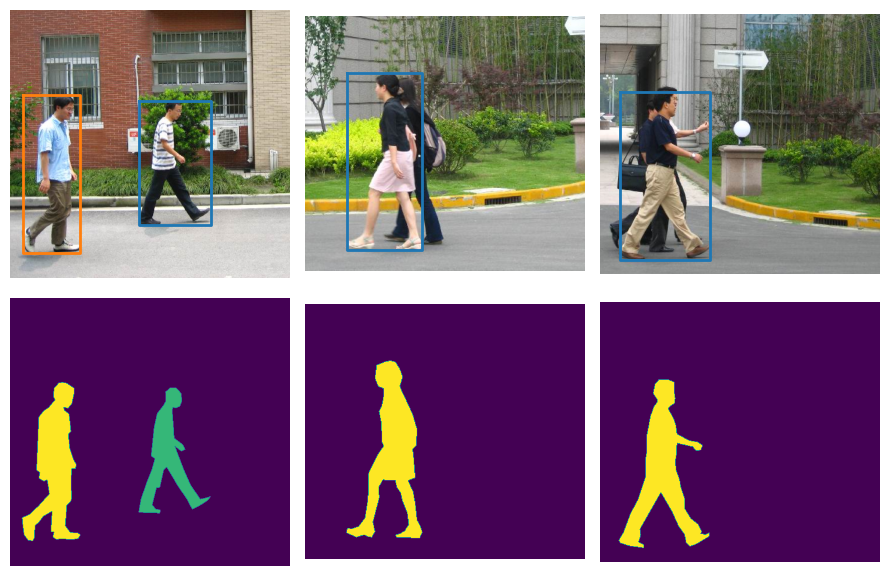

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6), dpi=100)

img_ids = (0, 1, 2)
for i_img in img_ids:
    example_img, example_target = dataset[i_img]
    example_masks = example_target["masks"]
    example_masks = example_masks + torch.where(
        example_masks,
        torch.arange(1, example_masks.shape[0] + 1, dtype=example_masks.dtype)[:,None,None],
        torch.zeros_like(example_masks),
    )
    example_masks = example_masks.sum(axis=0)

    plt.subplot(2, len(img_ids), i_img + 1)
    plt.imshow(example_img.permute(1, 2, 0))
    plt.axis("off")
    for bbox in example_target["boxes"]:
        plt.plot(
            [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]],
            [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]],
            linewidth=2.0
        )
    plt.subplot(2, len(img_ids), i_img + len(img_ids) + 1)
    plt.imshow(example_masks)
    plt.axis("off");

plt.tight_layout()

Now that we have our dataset, let's take a pre-trained Mask R-CNN from torchvision and see, what its predictions look like on the Penn-Fudan data.

*Note: we're predicting for the `example_img` created in the last iteration of the `for` loop from the previous cell.*

In [7]:
pretrained_maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
pretrained_maskrcnn.eval()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

with torch.autograd.no_grad():
    predictions = pretrained_maskrcnn.to(device)([example_img.to(device)])

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let's superimpose the prediction masks with the original image.

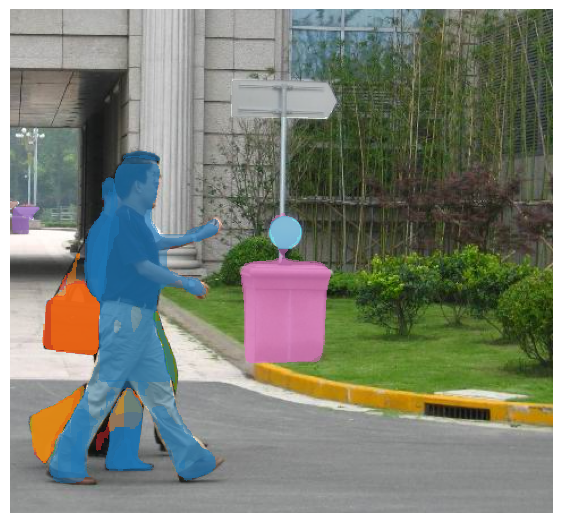

In [8]:
import matplotlib

plt.figure(figsize=(7, 7), dpi=100)
plt.imshow(example_img.permute(1, 2, 0));
plt.axis("off");

cycler = iter(plt.rcParams["axes.prop_cycle"])
mapped_colors = {}

for mask, category in zip(
    predictions[0]["masks"].squeeze(1).cpu().numpy(),
    predictions[0]["labels"].cpu().numpy()
):
    if category in mapped_colors:
        color = mapped_colors[category]
    else:
        color = next(cycler)["color"]
        mapped_colors[category] = color

    plt.imshow(
        np.ma.masked_array(mask, mask=(mask < 0.5)),
        alpha=0.5,
        cmap=matplotlib.colors.ListedColormap([color])
    )

Nice results! It seems like the model is highlighting a lot of stuff, though, while we only need to mark the pedestrians. In fact, we can just pick the 'person' category from the pre-trained model to achieve that. But that's not exciting enough... Instead, let's fine-tune the model on our data!

To do that, we'll get the pre-trained Mask R-CNN, chop some of its heads off and replace with brand new ones:

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Two classes (background and pedestrian).
test_model = get_model_instance_segmentation(num_classes=2)

Let's check, whether the model is compatible with the dataset. First, we create a data loader and get a single batch of data from it:

In [10]:
import utils

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn     # Since different images in the batch may be
                                    # of different spatial sizes, one cannot
                                    # stack them into a single tensor. This
                                    # function will do the job of putting them
                                    # in a list of tensors. Same applies to the
                                    # ground truth masks.
)
images, targets = next(iter(data_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Then, we make a forward pass through the model. Note that the model is implemented to behave differently in the `train` and `eval` modes:

In [11]:
# When in training mode, the model expects both images and targets,
# and returns a dictionary containing loss values.

test_model.train()
losses = test_model(images, targets)

for k, v in losses.items():
    print(k, v)

loss_classifier tensor(0.8015, grad_fn=<NllLossBackward0>)
loss_box_reg tensor(0.2806, grad_fn=<DivBackward0>)
loss_mask tensor(2.5532, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss_objectness tensor(0.0351, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss_rpn_box_reg tensor(0.0053, grad_fn=<DivBackward0>)


In [12]:
# When in test mode, the model takes the input images only and
# returns the list of prediction dictionaries:

test_model.eval()
outputs = test_model(images)
for out in outputs:
    print(out.keys())
    for k, v in out.items():
        print("\t", k, v.shape)

dict_keys(['boxes', 'labels', 'scores', 'masks'])
	 boxes torch.Size([100, 4])
	 labels torch.Size([100])
	 scores torch.Size([100])
	 masks torch.Size([100, 1, 318, 366])
dict_keys(['boxes', 'labels', 'scores', 'masks'])
	 boxes torch.Size([100, 4])
	 labels torch.Size([100])
	 scores torch.Size([100])
	 masks torch.Size([100, 1, 380, 509])


Seems like everything works as intended. Now we can run the training process.

*Note: running for 10 epochs may take about 20 minutes on collab. It should be ok to run for fewer epochs (at least 2-3) to finish the exercises from this notebook.*

In [13]:
from engine import train_one_epoch, evaluate

# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes=2)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:02:03  lr: 0.000090  loss: 4.3774 (4.3774)  loss_classifier: 0.9145 (0.9145)  loss_box_reg: 0.3892 (0.3892)  loss_mask: 3.0550 (3.0550)  loss_objectness: 0.0064 (0.0064)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 2.0549  data: 0.2881  max mem: 2554
Epoch: [0]  [10/60]  eta: 0:01:17  lr: 0.000936  loss: 1.4810 (2.2837)  loss_classifier: 0.5004 (0.5342)  loss_box_reg: 0.2493 (0.2524)  loss_mask: 0.9688 (1.4724)  loss_objectness: 0.0164 (0.0189)  loss_rpn_box_reg: 0.0045 (0.0058)  time: 1.5467  data: 0.0374  max mem: 3534
Epoch: [0]  [20/60]  eta: 0:01:02  lr: 0.001783  loss: 0.9159 (1.5531)  loss_classifier: 0.2306 (0.3775)  loss_box_reg: 0.2463 (0.2613)  loss_mask: 0.3761 (0.8879)  loss_objectness: 0.0164 (0.0197)  loss_rpn_box_reg: 0.0048 (0.0067)  time: 1.5352  data: 0.0122  max mem: 3534
Epoch: [0]  [30/60]  eta: 0:00:45  lr: 0.002629  loss: 0.5558 (1.1948)  loss_classifier: 0.1043 (0.2777)  loss_box_reg: 0.2095 (0.2294)  loss_mask: 0.1947 (0.6630)  loss_ob

Now, we'll write a function to make a prediction on a single image and plot the original image and the image superimposed with the predicted masks, side by side:

In [14]:
def eval_on_img(model, image):
    model.eval()
    with torch.autograd.no_grad():
        pred, = model([image.to(device)])

    pred_mask = pred["masks"].cpu().numpy().squeeze(1)
    for i in range(pred_mask.shape[0]):
        pred_mask[i] = np.where(pred_mask[i] > 0.5, i + 1, 0)
    pred_mask = pred_mask.max(axis=0)
    pred_mask = np.ma.masked_array(pred_mask, mask=(pred_mask == 0))

    plt.figure(figsize=(9, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0));
    plt.axis("off");

    plt.subplot(1, 2, 2)
    plt.imshow(image.permute(1, 2, 0));
    plt.imshow(pred_mask, alpha=0.9);
    plt.axis("off");

    plt.tight_layout();

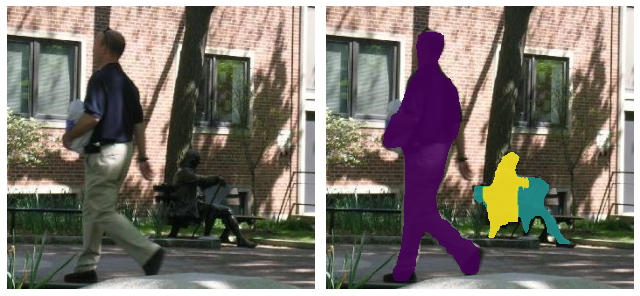

In [15]:
test_img, _ = next(iter(dataset_test))
eval_on_img(model, test_img)

Let's see what our model would predict on an image outside of our dataset:

--2021-11-29 10:13:17--  https://upload.wikimedia.org/wikipedia/en/1/18/Inception_OST.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55512 (54K) [image/jpeg]
Saving to: ‘Inception_OST.jpg.1’

Inception_OST.jpg.1 100%[===================>]  54.21K  --.-KB/s    in 0.04s   

2021-11-29 10:13:17 (1.47 MB/s) - ‘Inception_OST.jpg.1’ saved [55512/55512]



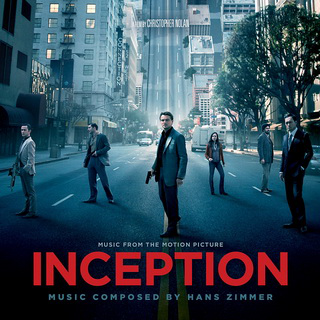

In [37]:
!wget https://upload.wikimedia.org/wikipedia/en/1/18/Inception_OST.jpg

external_img = Image.open("Inception_OST.jpg").convert("RGB")
external_img

## Task 1 (1 point)

Now it's your turn to apply our model on this image. Use the `eval_on_img` function defined above. Don't forget to convert `external_img` to a torch tensor.

In [30]:
import torch

from torchvision import transforms

from PIL import Image

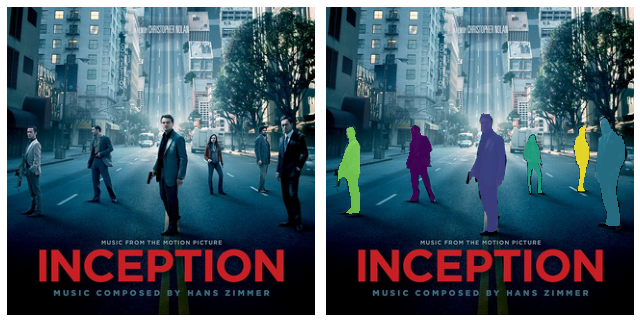

In [41]:
# <YOUR CODE>
# convert_tensor = transforms.ToTensor()
# external_img = convert_tensor(external_img)
eval_on_img(model, external_img)

## Task 2 (5 points)

**Final quest**

This last task intends you to dig a little into the insides of the model. The overall goal here is to plot the map of the RPNs attention (objectness scores) to the input image (`external_img`).

To find out how to do this, check out what's happening in our model's [forward call](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/generalized_rcnn.py#L42) (for simplicity, let's only consider the `eval` mode, i.e., `self.training = False` and `targets = None`).

As you should know from the theoretical material, the RPN (Region Proposal Network) is a separate head that acts on the convolutional features obtained by the main fully convolutional backbone of the model. Try to locate where this happens in the code. Note that RPN's forward call [already returns the proposed regions](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/generalized_rcnn.py#L96), rather than the objectness scores, so we'll need to go deeper into the code to get the RPN's objectness scores. That is, we need to look inside [the RPN's forward method](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/rpn.py#L319). Note, by the way, that the RPN is tructured to have its own separate head for [predicting the objectness scores](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/rpn.py#L343).

From the docstring and the annotations, we can see that the convolutional features (the `features` argument) is expected to be a dictionary. The reason for that is that RPN looks at different scales of the convolutional features and makes its predictions for each scale. So, this dictionary has a separate entry for each of the scales. Since, by design, RPN predicts the objectness scores (and corresponding bounding boxes) for anchors centered at **each of the pixels in the convolutional feature map**, the output of the RPN is going to be a set of image-like objectess maps. These are the maps that we want to plot. Each map is going to have multiple channels - one for each of the anchors in a given pixel. You can plot these channels separetly, or, alternatively, you can take the maximum objectess score for each of the pixels.

So, to sum up, you need to do the following things:
- [transform the input image](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/generalized_rcnn.py#L77), (1 point)
- [calculate the convolutional features](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/generalized_rcnn.py#L93), (1 point)
- [calculate the RPN's objectness score maps](https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/rpn.py#L343), (1 point)
- \[optionally\] get the maximum value at each pixel of each of the objectness score maps, (1 point)
- plot each of the resulting maps using `plt.imshow`. (1 point)

Try to visually compare the original `external_img` input image with the obtained RPN's attention maps. Which areas of the image got the most attention?

In [ ]:
from torchvision.models.detection import rpn

In [ ]:
# For reference, see the `forward` methods code for the main model and its RPN:
#     https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/generalized_rcnn.py#L42
#     https://github.com/pytorch/vision/blob/c50d0fccd5b0b47dea162b4dac2fd94ae21e522f/torchvision/models/detection/rpn.py#L319

def get_rpm_output(model, image):
    model.eval()
    with torch.autograd.no_grad():
        imgs = [image]
        # <YOUR CODE>
        imgs = rpn.transform(imgs)
        features = rpn.backbone(imgs.tensors)
        # features = list(features.values())
        proposal_scores = rpn(imgs, features)
        proposal_scores = list(proposal_scores.values)
    # `proposal_scores` should be a list of rpn's proposal score maps
    return proposal_scores

proposals = get_rpm_output(model, T.F.to_tensor(external_img).to(device))

# Feel free to adjust this part for a nicer plot:
plt.figure(figsize=(30, 10))
for i, prop in enumerate(proposals, 1):
    plt.subplot(1, len(proposals), i)
    plt.imshow(prop.cpu(), interpolation="nearest")
    plt.axis("off")
